# Peptide Detectability (Training and fine tuning) 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook provides a concise walkthrough of the process for reading a dataset, training, and fine-tuning a model for peptide detectability prediction. 

The dataset used in this example is derived from:

- **ProteomTools Dataset**: Includes data from the PRIDE repository with the following identifiers: `PXD004732`, `PXD010595`, and `PXD021013`.
- **MAssIVE Dataset**: Deposited in the ProteomeXchange Consortium via the MAssIVE partner repository with the identifier `PXD024364`.

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

In [1]:
# # install the DLOmix package in the current environment using pip

# !python -m pip install -q git+https://github.com/wilhelm-lab/dlomix

The available modules in the framework are as follows:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import dlomix
import sys
import os

In [3]:
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/data')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/models')
sys.path.append('C:/Users/JZ05DL/OneDrive - Aalborg Universitet/Desktop/Naim code for dlomix/dlomix/dlomix/reports')

- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around TensorFlow Dataset
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations (e.g. Detectability Prediction)
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)
- `utils`: helper modules

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

## 1. Load Data

We can import the dataset class and create an object of type `detectability_dataset`. This object wraps around TensorFlow dataset objects for training, validation, and testing or for only testing. This can be specified by the arguments `val_ratio`, `test_ratio` and `test`.

**Note**: If the classes are provided the following encoding should be used: Non-Flyer: 0, Weak Flyer: 1, Intermediate Flyer: 2, Strong Flyer: 3.

In [4]:
from dlomix.data.detectability_dataset import detectability_dataset

In [5]:
TRAIN_DATAPATH = './example_dataset/detectability_data.csv'

max_pep_length = 40
BATCH_SIZE = 128
            
detectability_data = detectability_dataset(data_source = TRAIN_DATAPATH, 
                                           #protein_data = np.array([x.upper() for x in protein_data]),
                                           seq_length = max_pep_length,
                                           split_on_protein = False, 
                                           batch_size = BATCH_SIZE, 
                                           val_ratio = 0.1, 
                                           test_ratio = 0.2, 
                                           test = False)

The detectability dataset can be directly used with both standard or custom `Keras` models. This dataset wrapper includes predefined splits for training, validation, and testing. The corresponding data subsets can be accessed through the attributes `.train_data`, `.val_data` and `.test_data`. The length of each subset is expressed in terms of batches, where the total number of examples is calculated as `total examples = batch_size x len`. In case the parameter `test = True` is set, only the test dataset is generated.

In [6]:
 "Training examples", BATCH_SIZE * len(detectability_data.train_data)

('Training examples', 237440)

In [7]:
"Validation examples", BATCH_SIZE * len(detectability_data.val_data)

('Validation examples', 26496)

In [8]:
"Test examples", BATCH_SIZE * len(detectability_data.test_data)

('Test examples', 66048)

It is also possible to obtain the different datasets as DataFrames by calling the `.get_split_dataframe` method and specifying the desired dataset split: `train`, `val` and `test`.

In [9]:
test_data_df = detectability_data.get_split_dataframe(split = "test")
test_data_df.head(5)

,Sequences,Classes
0,GTVDKKMVEK,0
1,TFWNLNMRGLGGEGGTEEESSLGQAGGK,1
2,DIRQFQMK,3
3,DPAILDNEGTSALAIALEAEQ,0
4,AYLVLDPLIYFGPFA,0


## 2. Model

We can now create the model. The model architecture is an encoder-decoder with an attention mechanism, that is based on Bidirectional Recurrent Neural Network (BRNN) with Gated Recurrent Units (GRU). Both the Encoder and Decoder consists of a single layer, with the Decoder also including a Dense layer. The model has the default working arguments.

**Note**: It is important to ensure that the padding length used in the dataset object matches the sequence length passed to the model.

In [10]:
from dlomix.models import detetability_model
from dlomix.detectability_model_constants import CLASSES_LABELS, alphabet

In [11]:
total_num_classes = len(CLASSES_LABELS)
input_dimension = len(alphabet)
num_cells = 64

model = detetability_model.detetability_model(num_units = num_cells,
                                              num_clases = total_num_classes)

## 3. Training and saving the model

You can train the model using the standard Keras approach. The training parameters provided here are those initially configured for the detectability model. However, you have the flexibility to modify these parameters, including adjusting the optimizer settings, to suit your specific needs.

In [12]:
# compile the model  with the optimizer and the metrics we want to use

# you can also import tensorflow and build your custom optimizer object and pass it

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            mode = 'min', 
                                            verbose = 1, 
                                            patience = 5)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'output/weights/new_base_model/base_model_weights',
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1,
                                                      save_best_only = True, 
                                                      save_weights_only = True)

model.compile(optimizer = 'adam',
              loss = 'CategoricalCrossentropy',
              metrics = 'categorical_accuracy')

We save the results of the training process to enable a detailed examination of the metrics and losses at a later stage. We define the number of epochs for training and supply the training and validation data previously generated. This approach allows us to effectively monitor the model’s performance and make any necessary adjustments.

In [13]:
history = model.fit(detectability_data.train_data,
                    validation_data = detectability_data.val_data,
                    epochs = 50, 
                    callbacks=[callback, model_checkpoint])

Epoch 1/50
1853/1855 [============================>.] - ETA: 0s - loss: 0.9150 - categorical_accuracy: 0.5885
Epoch 1: val_categorical_accuracy improved from -inf to 0.61813, saving model to output/weights/new_base_model\base_model_weights
1855/1855 [==============================] - 48s 21ms/step - loss: 0.9150 - categorical_accuracy: 0.5885 - val_loss: 0.8613 - val_categorical_accuracy: 0.6181
Epoch 2/50
1852/1855 [============================>.] - ETA: 0s - loss: 0.8413 - categorical_accuracy: 0.6225
Epoch 2: val_categorical_accuracy improved from 0.61813 to 0.62894, saving model to output/weights/new_base_model\base_model_weights
1855/1855 [==============================] - 40s 21ms/step - loss: 0.8414 - categorical_accuracy: 0.6225 - val_loss: 0.8292 - val_categorical_accuracy: 0.6289
Epoch 3/50
1855/1855 [==============================] - ETA: 0s - loss: 0.8158 - categorical_accuracy: 0.6345
Epoch 3: val_categorical_accuracy improved from 0.62894 to 0.63834, saving model to outpu

## 3. Testing and Reporting


In the following cell, you need to specify the path to the model weights you wish to use. The default path provided is set to the weights for the new base model, which is used in the current setup.

- **Using the Default Base Model Weights**: If you are using the weights for the new base model as specified, you can keep the default path unchanged. This will load the weights for the base model used in this setup.

- **Using Different Weights**: If you intend to use different weights, such as for an alternative model or a custom setup, you should update the path to point to the location of these weights. Replace the default path with the path to the weights file for the model you are using.

In [14]:
## Loading best model's weights 

model.load_weights('output/weights/new_base_model/base_model_weights')

We use the test dataset to assess our model's performance, which is only applicable if labels are available.

In [15]:
# use model.predict from keras directly on the testdata

predictions = model.predict(detectability_data.test_data)

516/516 [==============================] - 7s 8ms/step


In [16]:
# To calculate evaluation metrics against predictions, we need to obtain the targets and dataframes for a specific dataset split. 
# The `get_split_targets` and `get_split_dataframe` functions from the `detectability_dataset` class facilitate this process.

test_targets = detectability_data.get_split_targets(split = "test")
test_data_df = detectability_data.get_split_dataframe(split = "test")

In [17]:
from dlomix.reports.detectability_report import detectability_report, predictions_report
WANDB_REPORT_API_DISABLE_MESSAGE=True

wandb: WARNING The v1 API is deprecated and will be removed in a future release.  Please move to v2 by setting the env var WANDB_REPORT_API_ENABLE_V2=True.  This will be on by default in a future release.
wandb: WARNING You can disable this message by setting the env var WANDB_REPORT_API_DISABLE_MESSAGE=True


The `detectability_report` class allows us to compute various metrics, generate reports, and create plots for a comprehensive evaluation of the model.

#### Generate a report using the `detectability_report` class by providing the following parameters:

- **targets**: The true labels for the dataset, used to evaluate the model's performance.
- **predictions**: The model's output predictions for the dataset, which will be compared against the targets.
- **input_data_df**: The DataFrame containing the input data used for generating predictions.
- **output_path**: The path where the generated report will be saved.
- **history**: The training history object (e.g., containing metrics from training) if available. Set this to `None` if not applicable, such as when the report is generated for predictions without training.
- **rank_by_prot**: A parameter indicating whether to rank peptides by their associated proteins. 
- **threshold**: The threshold value used for classification. This parameter helps in determining the decision boundary for classification tasks. The default is `None`, which means no specific threshold is applied.
- **name_of_dataset**: The name of the dataset used for generating the predictions. This information will be included in the report to provide context about the specific data set on which the predictions were made.
- **name_of_model**: The name of the model used to generate the predictions. This will be noted in the report to specify which model was employed and provide context regarding the predictions.

Note: The reporting module is currently under development, so some features may be unstable or subject to change.

In [18]:
report = detectability_report(targets = test_targets, 
                              predictions = predictions, 
                              input_data_df = test_data_df,
                              output_path = "./output/reports/report_on_ProteomeTools", 
                              history = history, 
                              rank_by_prot = False,
                              threshold = None,
                              name_of_dataset = 'ProteomeTools',
                              name_of_model = 'Base model (new)')

Binary Accuracy: 0.94

Categorical Accuracy: 0.65

Matthews Correlation Coefficient (MCC): 0.85

True Positive Rate (Recall): 0.97

False Positive Rate (Specificity): 0.87

Precision: 0.96

F1 Score: 0.96


In [19]:
results_df = report.detectability_report_table
results_df

,Sequences,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions
0,GTVDKKMVEK,0.004,0.001,0.000,0.996,0.005,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
1,TFWNLNMRGLGGEGGTEEESSLGQAGGK,0.904,0.067,0.001,0.029,0.972,Weak Flyer,Weak Flyer,Flyer,Flyer
2,DIRQFQMK,0.044,0.239,0.689,0.028,0.972,Strong Flyer,Strong Flyer,Flyer,Flyer
3,DPAILDNEGTSALAIALEAEQ,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
4,AYLVLDPLIYFGPFA,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
...,...,...,...,...,...,...,...,...,...,...
65947,CLGHLFLSLGMVYLR,0.092,0.004,0.000,0.904,0.096,Weak Flyer,Non-Flyer,Flyer,Non-Flyer
65948,GLDCIFLETNMSMK,0.326,0.487,0.162,0.025,0.975,Intermediate Flyer,Intermediate Flyer,Flyer,Flyer
65949,QAQLQALETTAK,0.142,0.493,0.343,0.022,0.978,Weak Flyer,Intermediate Flyer,Flyer,Flyer
65950,RTMESLEQVPLK,0.200,0.545,0.223,0.032,0.968,Intermediate Flyer,Intermediate Flyer,Flyer,Flyer


In [20]:
# directory = './output/reports/report_on_Sinitcyn_training'

# if not os.path.exists(directory):
#     os.makedirs(directory)

# path_ = directory + "/predictions.csv"
    
# results_df.to_csv(path_, index=False)

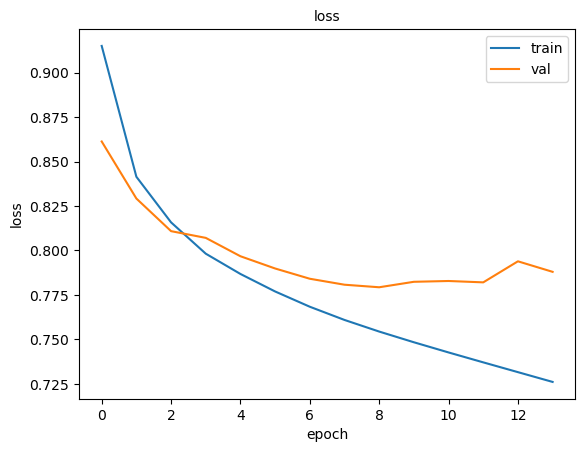

In [21]:
report.plot_keras_metric("loss")

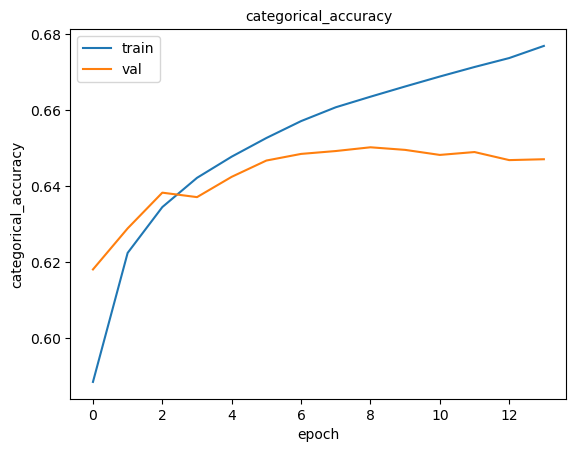

In [22]:
report.plot_keras_metric("categorical_accuracy")

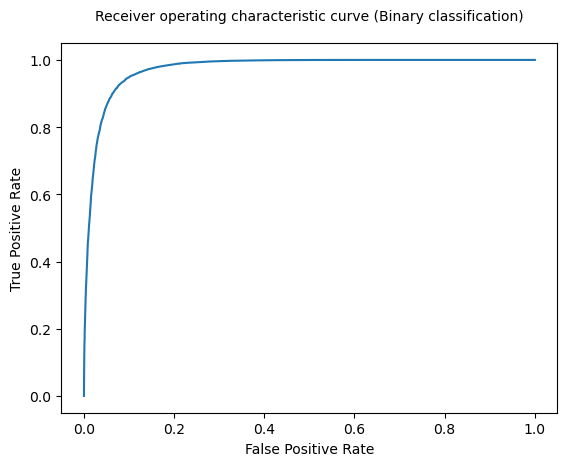

In [23]:
report.plot_roc_curve_binary()

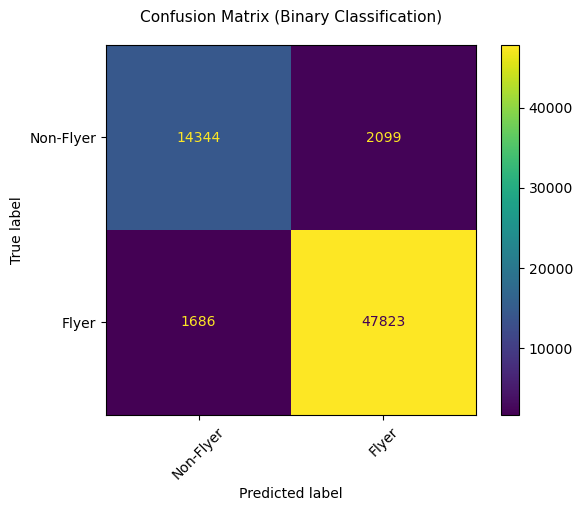

In [24]:
report.plot_confusion_matrix_binary()

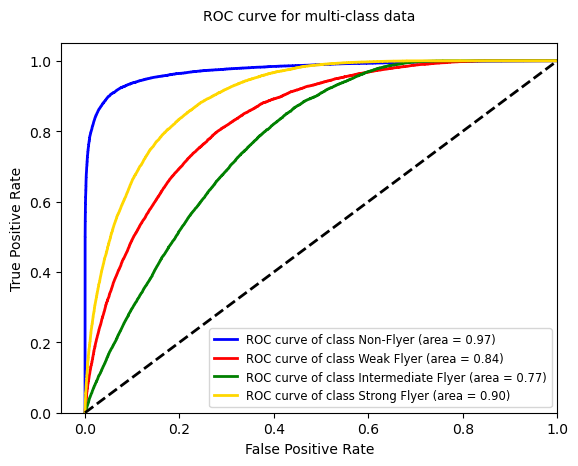

In [25]:
report.plot_roc_curve()

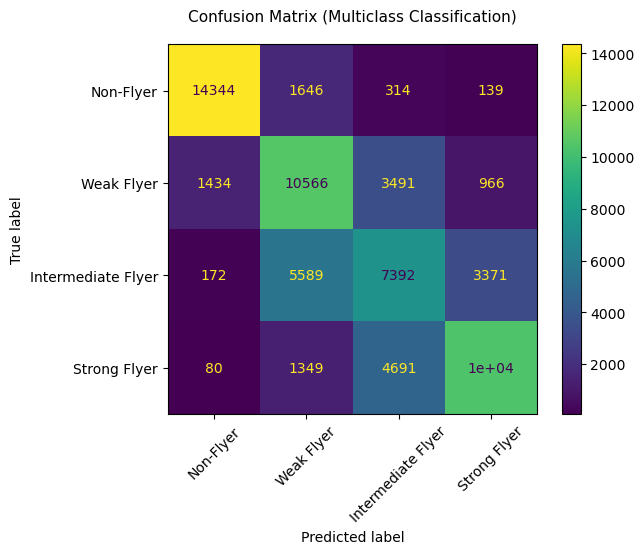

In [26]:
report.plot_confusion_matrix_multiclass()

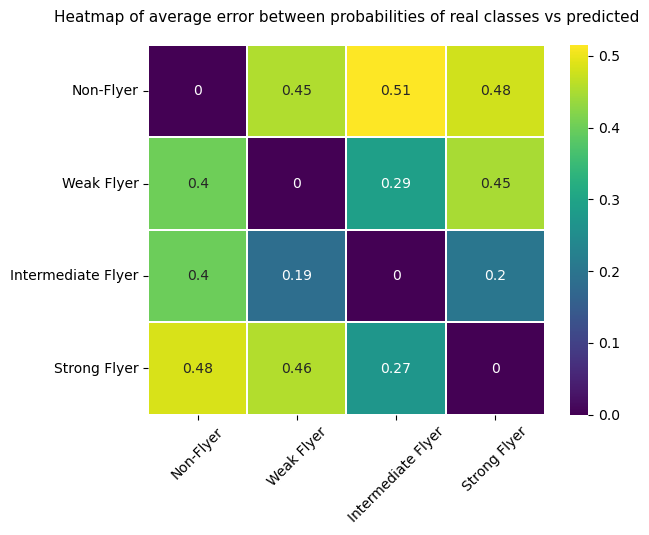

In [27]:
report.plot_heatmap_prediction_prob_error()

We can also produce a complete report with all the relevant plots in one PDF file by calling the `generate_report` function.

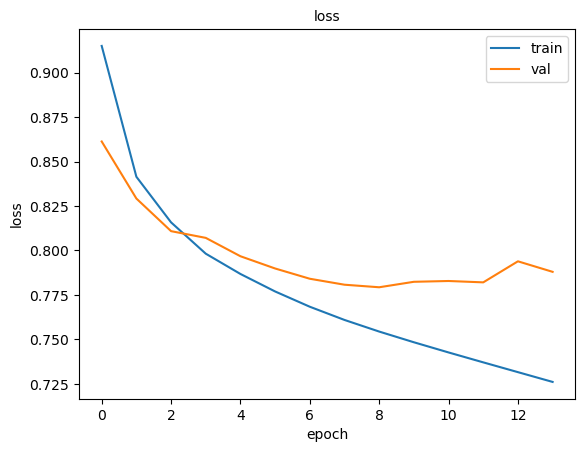

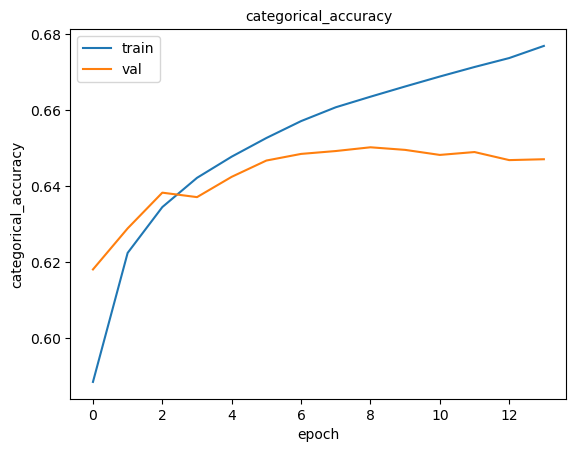

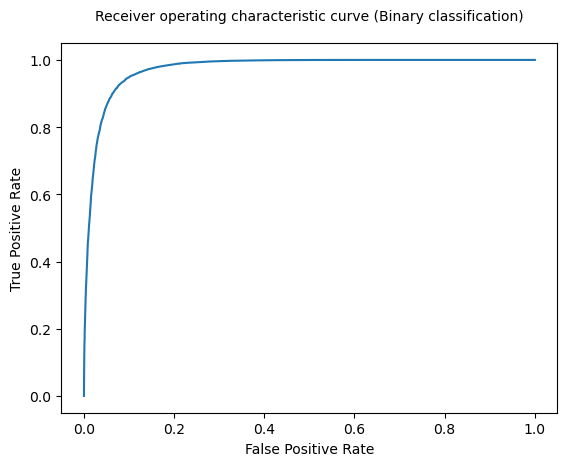

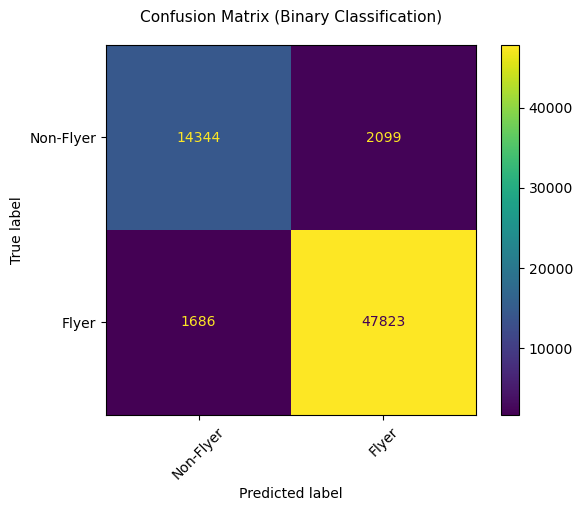

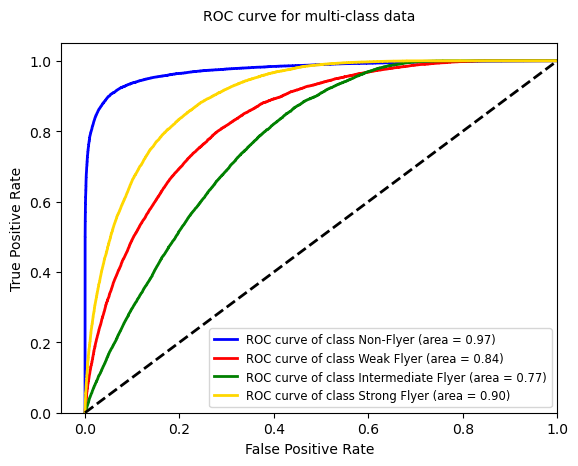

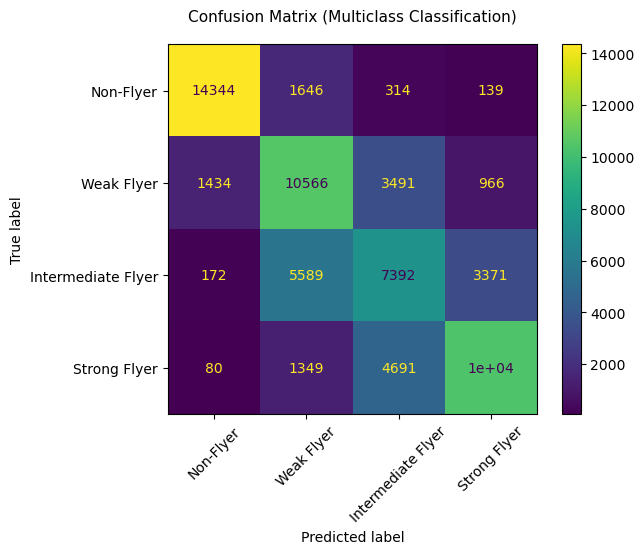

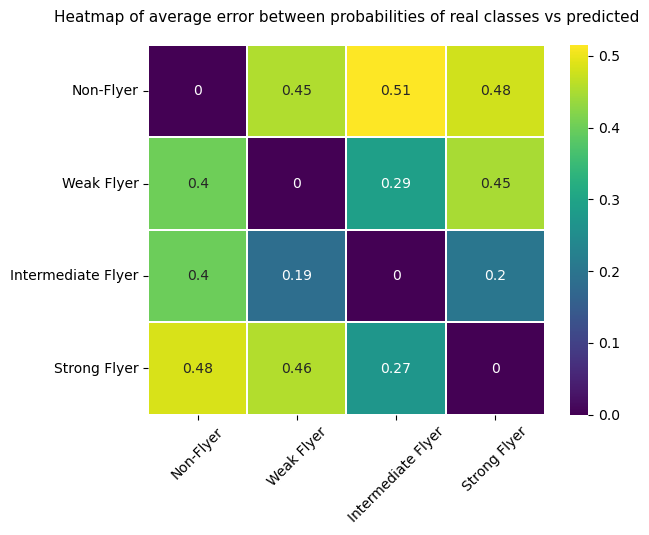

In [28]:
report.generate_report()

Here is an example defining a threshold

In [29]:
report_using_threshold = detectability_report(test_targets, 
                                              predictions, 
                                              test_data_df, 
                                              output_path = "./output/reports/report_on_ProteomeTools_with_threshold", 
                                              history = history, 
                                              threshold = 0.02,                              
                                              name_of_dataset = 'ProteomeTools',
                                              name_of_model = 'Base model (new) with threshold')

Binary Accuracy: 0.64

Categorical Accuracy: 0.48

Matthews Correlation Coefficient (MCC): 0.45

True Positive Rate (Recall): 0.52

False Positive Rate (Specificity): 0.99

Precision: 0.99

F1 Score: 0.68


In [30]:
report_using_threshold.detectability_report_table

,Sequences,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions
0,GTVDKKMVEK,0.004,0.001,0.000,0.996,0.005,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
1,TFWNLNMRGLGGEGGTEEESSLGQAGGK,0.904,0.067,0.001,0.029,0.972,Weak Flyer,Non-Flyer,Flyer,Non-Flyer
2,DIRQFQMK,0.044,0.239,0.689,0.028,0.972,Strong Flyer,Non-Flyer,Flyer,Non-Flyer
3,DPAILDNEGTSALAIALEAEQ,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
4,AYLVLDPLIYFGPFA,0.000,0.000,0.000,1.000,0.000,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
...,...,...,...,...,...,...,...,...,...,...
65947,CLGHLFLSLGMVYLR,0.092,0.004,0.000,0.904,0.096,Weak Flyer,Non-Flyer,Flyer,Non-Flyer
65948,GLDCIFLETNMSMK,0.326,0.487,0.162,0.025,0.975,Intermediate Flyer,Non-Flyer,Flyer,Non-Flyer
65949,QAQLQALETTAK,0.142,0.493,0.343,0.022,0.978,Weak Flyer,Non-Flyer,Flyer,Non-Flyer
65950,RTMESLEQVPLK,0.200,0.545,0.223,0.032,0.968,Intermediate Flyer,Non-Flyer,Flyer,Non-Flyer


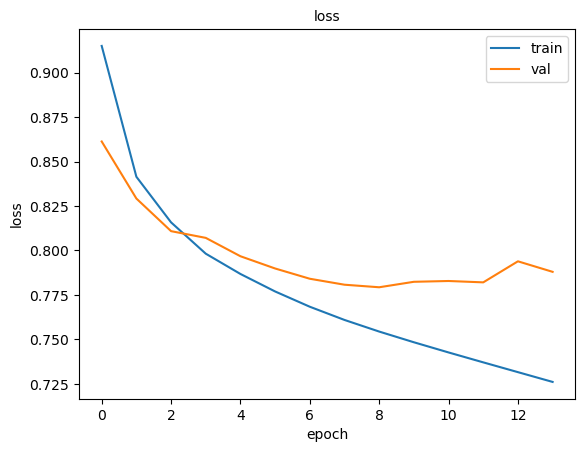

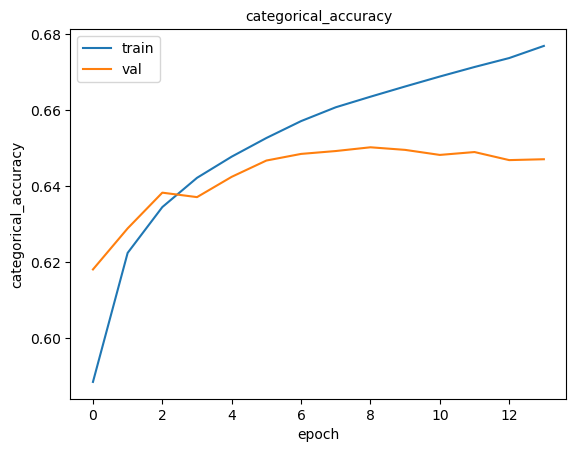

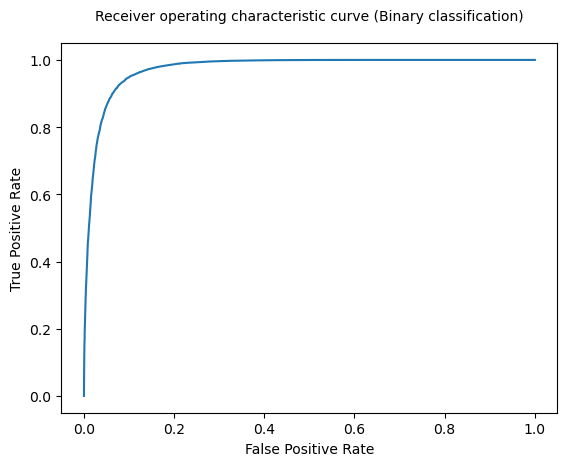

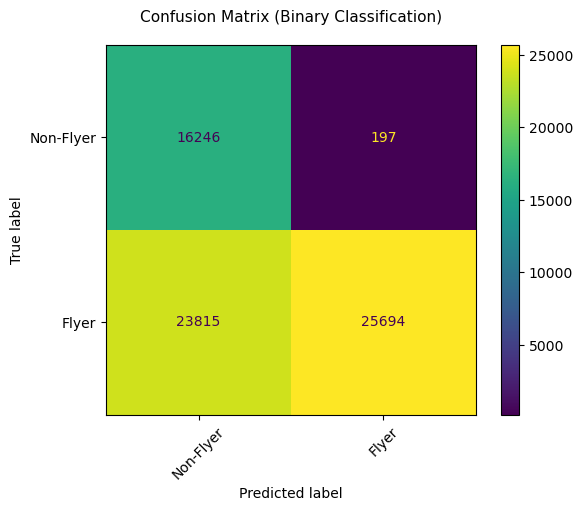

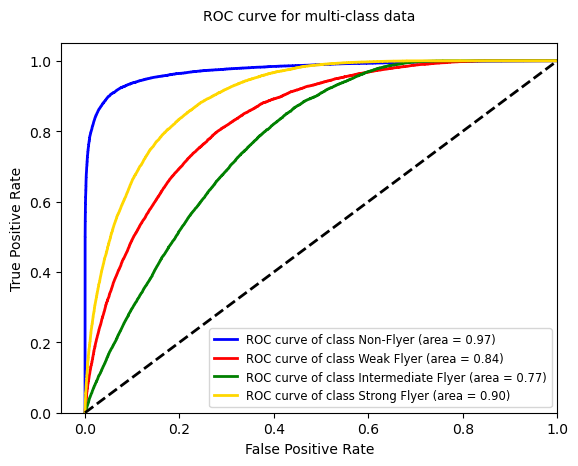

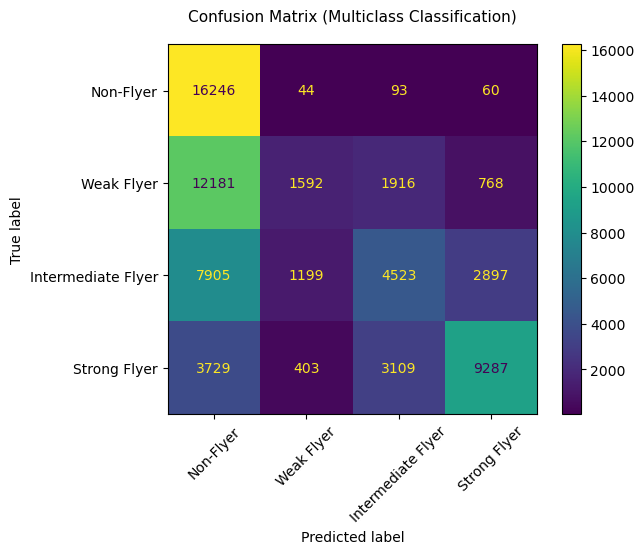

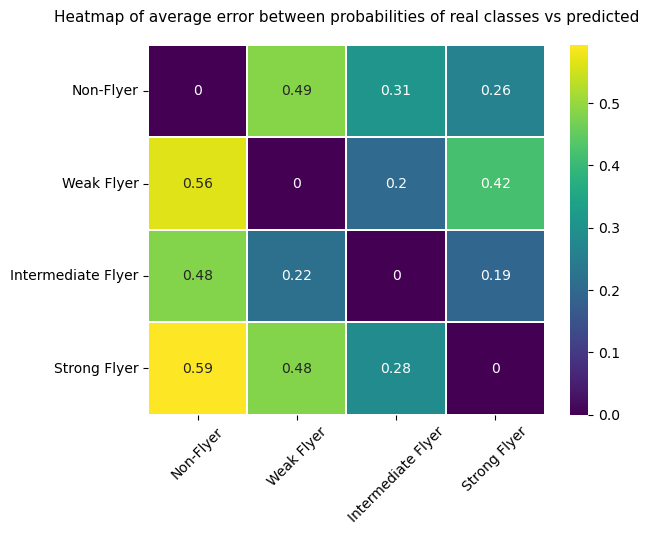

In [31]:
report_using_threshold.generate_report()

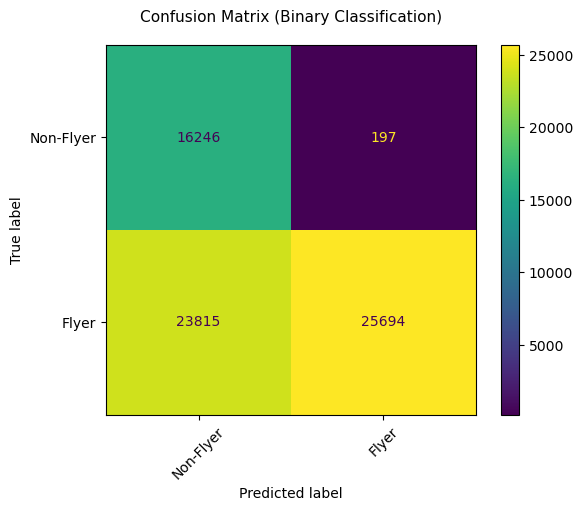

In [32]:
report_using_threshold.plot_confusion_matrix_binary()

## 4. Load data for fine tuning

For fine tuning we follow the same steps as in training. We create an object of type `detectability_dataset` with the data for fine tuning.

In [33]:
TRAIN_DATAPATH = './example_dataset/Sinitcyn_train_data.csv'

max_pep_length = 40
BATCH_SIZE = 128
            
fine_tune_data = detectability_dataset(data_source = TRAIN_DATAPATH, 
                                       protein_data = "proteins",
                                       split_on_protein = True, 
                                       seq_length = max_pep_length, 
                                       batch_size = BATCH_SIZE, 
                                       val_ratio = 0.1, 
                                       test_ratio = 0.2, 
                                       test = False)

In [34]:
 "Training examples", BATCH_SIZE * len(fine_tune_data.train_data) 

('Training examples', 176256)

In [35]:
 "Validation examples", BATCH_SIZE * len(fine_tune_data.val_data)

('Validation examples', 20224)

In [36]:
"Test examples", BATCH_SIZE * len(fine_tune_data.test_data)

('Test examples', 48384)

## 4. Fine tuning the model

We create the model and we load the weights of the model to fine tune.

In [37]:
# models can be later loaded by creating a model object and then loading the weights

save_path = "./output/weights/new_base_model/base_model_weights"

fine_tuned_model = detetability_model.detetability_model(num_units = num_cells,  
                                                         num_clases = total_num_classes)

fine_tuned_model.load_weights(save_path)

In [38]:
# compile the model  with the optimizer and the metrics we want to use.

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            mode = 'min', 
                                            verbose = 1, 
                                            patience = 5)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'output/weights/new_fine_tuned_model/fine_tuned_model_weights',
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1,
                                                      save_best_only = True, 
                                                      save_weights_only = True)

fine_tuned_model.compile(optimizer = 'adam',
                         loss = 'CategoricalCrossentropy',
                         metrics = 'categorical_accuracy')

We store the result of training so that we can explore the metrics and the losses later. We specify the number of epochs for training and pass the training and validation data as previously described.

In [39]:
history_fine_tuned = fine_tuned_model.fit(fine_tune_data.train_data,
                                          validation_data = fine_tune_data.val_data,
                                          epochs = 50, 
                                          callbacks=[callback, model_checkpoint])

Epoch 1/50
1376/1377 [============================>.] - ETA: 0s - loss: 1.2560 - categorical_accuracy: 0.3959
Epoch 1: val_categorical_accuracy improved from -inf to 0.41161, saving model to output/weights/new_fine_tuned_model\fine_tuned_model_weights
1377/1377 [==============================] - 38s 22ms/step - loss: 1.2560 - categorical_accuracy: 0.3959 - val_loss: 1.2317 - val_categorical_accuracy: 0.4116
Epoch 2/50
1375/1377 [============================>.] - ETA: 0s - loss: 1.2328 - categorical_accuracy: 0.4086
Epoch 2: val_categorical_accuracy improved from 0.41161 to 0.41433, saving model to output/weights/new_fine_tuned_model\fine_tuned_model_weights
1377/1377 [==============================] - 30s 21ms/step - loss: 1.2329 - categorical_accuracy: 0.4086 - val_loss: 1.2267 - val_categorical_accuracy: 0.4143
Epoch 3/50
1377/1377 [==============================] - ETA: 0s - loss: 1.2267 - categorical_accuracy: 0.4127
Epoch 3: val_categorical_accuracy improved from 0.41433 to 0.4194

In [40]:
## Loading best model's weights 

fine_tuned_model.load_weights('output/weights/new_fine_tuned_model/fine_tuned_model_weights')

In [41]:
# use model.predict from keras directly on the testdata

predictions_FT = fine_tuned_model.predict(fine_tune_data.test_data)

378/378 [==============================] - 5s 7ms/step


In [42]:
# we can get the targets and dataframes of a specific split to calcualte evaluation metrics against predictions
# the get_split_targets and get_split_dataframe functions from the detectability dataset do this

test_targets_FT = fine_tune_data.get_split_targets(split = "test")
test_data_df_FT = fine_tune_data.get_split_dataframe(split = "test")

In [43]:
# create a report object by passing the test targets, predictions, and history object and plot different metrics

report_FT = detectability_report(test_targets_FT, 
                                 predictions_FT, 
                                 test_data_df_FT, 
                                 output_path = "./output/reports/report_on_Sinitcyn (Fine tuned model)", 
                                 history = history_fine_tuned, 
                                 threshold = None,                              
                                 name_of_dataset = 'Sinitcyn test subset',
                                 name_of_model = 'Fine tuned model (new)')

Binary Accuracy: 0.8

Categorical Accuracy: 0.41

Matthews Correlation Coefficient (MCC): 0.46

True Positive Rate (Recall): 0.88

False Positive Rate (Specificity): 0.57

Precision: 0.86

F1 Score: 0.87


In [44]:
results_df_FT = report_FT.detectability_report_table
results_df_FT

,Sequences,Proteins,Weak Flyer,Intermediate Flyer,Strong Flyer,Non-Flyer,Flyer,Classes,Predictions,Binary Classes,Binary Predictions
0,MASELGAR,Q9ULG1,0.141,0.123,0.080,0.655,0.344,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
1,ECSSHQPCQGGPWVTGTSAVPPSEPILSYENILK,Q96F83,0.307,0.341,0.177,0.175,0.825,Non-Flyer,Intermediate Flyer,Non-Flyer,Flyer
2,YNLGDYNGEIMSEVMAQR,Q9H2F5,0.242,0.252,0.421,0.085,0.915,Weak Flyer,Strong Flyer,Flyer,Flyer
3,RPRPPAGSPAR,Q13202,0.083,0.016,0.010,0.891,0.109,Non-Flyer,Non-Flyer,Non-Flyer,Non-Flyer
4,VQPVMAPDVPATPVAPTESQTVLDALQQR,Q5T0F9,0.172,0.277,0.364,0.187,0.813,Strong Flyer,Strong Flyer,Flyer,Flyer
...,...,...,...,...,...,...,...,...,...,...,...
48303,CMSTSASALLACVR,Q9H1K6,0.365,0.292,0.135,0.209,0.792,Weak Flyer,Weak Flyer,Flyer,Flyer
48304,LPTWGTGASAGSGLR,O15534,0.308,0.311,0.244,0.137,0.863,Weak Flyer,Intermediate Flyer,Flyer,Flyer
48305,DSGHGSTSVDSEGFSIPDTGSHCSSEYAASSPGDR,P54278,0.451,0.176,0.065,0.309,0.692,Intermediate Flyer,Weak Flyer,Flyer,Flyer
48306,STHALSEVEVESDSFMNAVLWLR,P13798,0.225,0.156,0.068,0.551,0.449,Intermediate Flyer,Non-Flyer,Flyer,Non-Flyer


In [45]:
directory = './output/reports/report_on_Sinitcyn_fine_tuning'

if not os.path.exists(directory):
    os.makedirs(directory)

path_ = directory + "/predictions.csv"

results_df_FT.to_csv(path_, index=False)

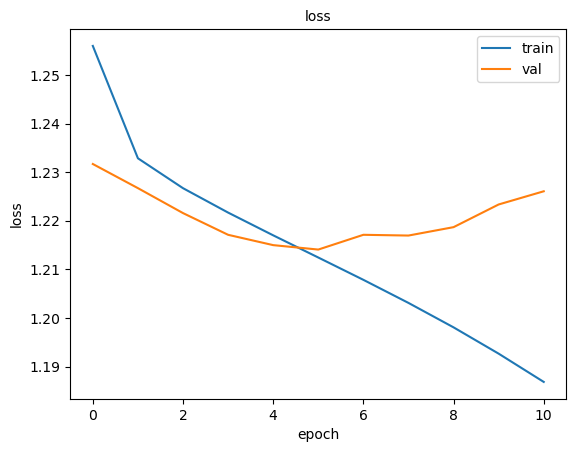

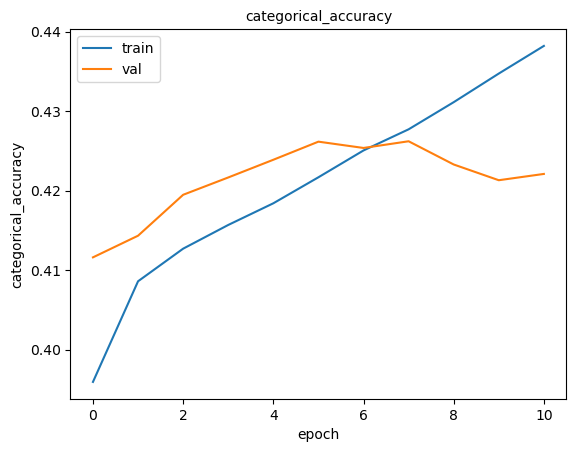

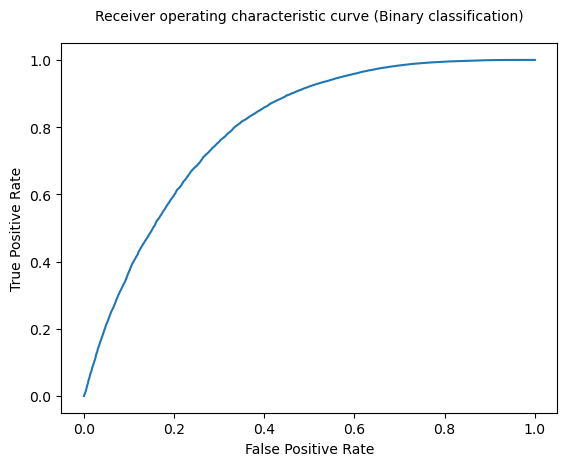

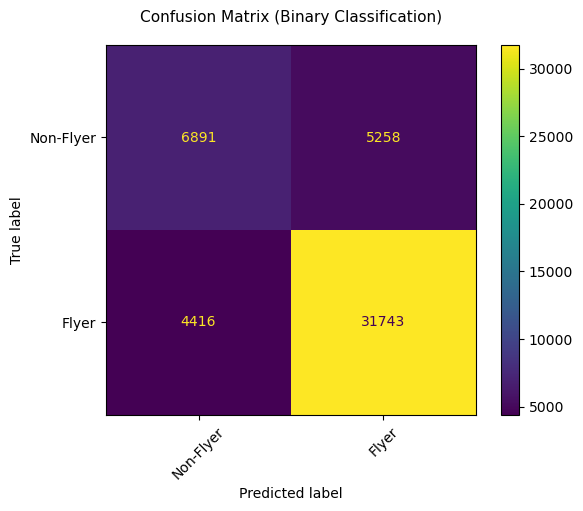

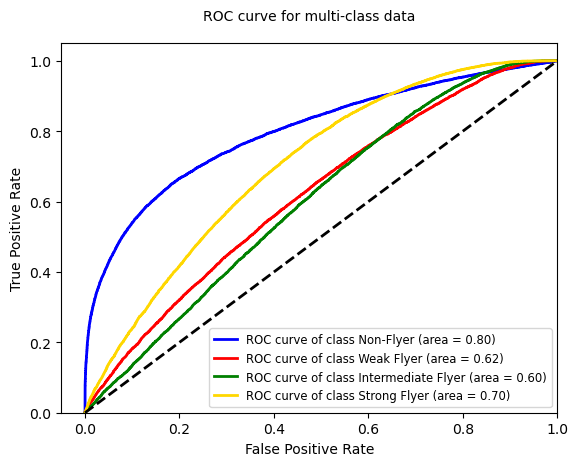

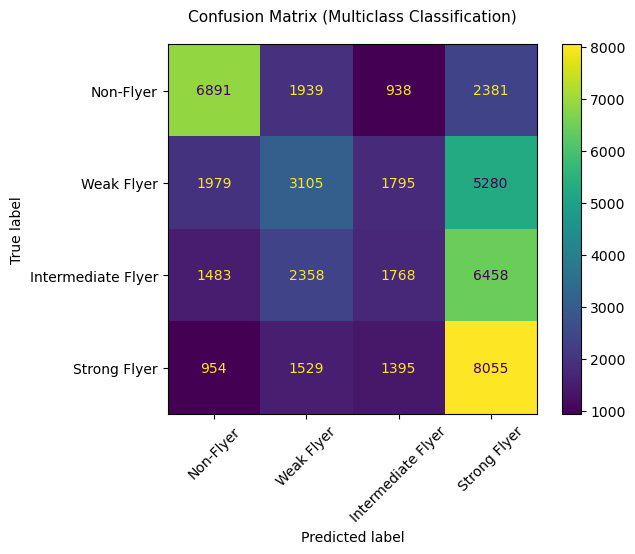

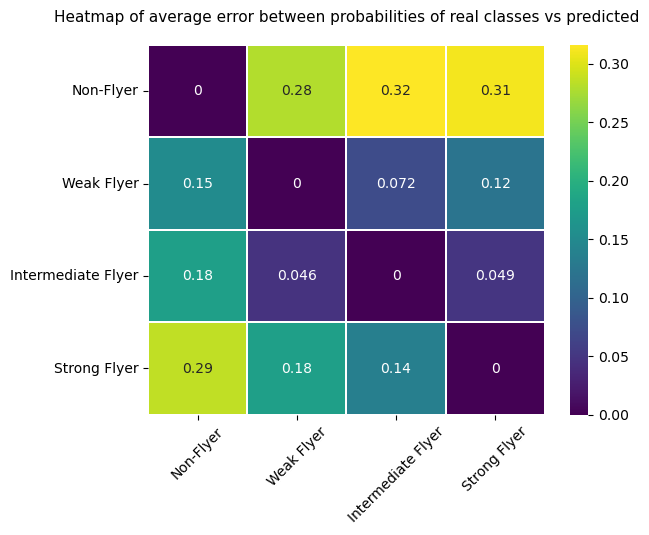

In [46]:
report_FT.generate_report()

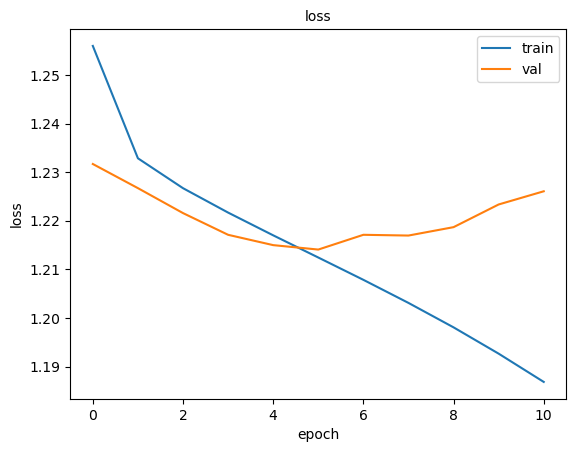

In [47]:
report_FT.plot_keras_metric("loss")

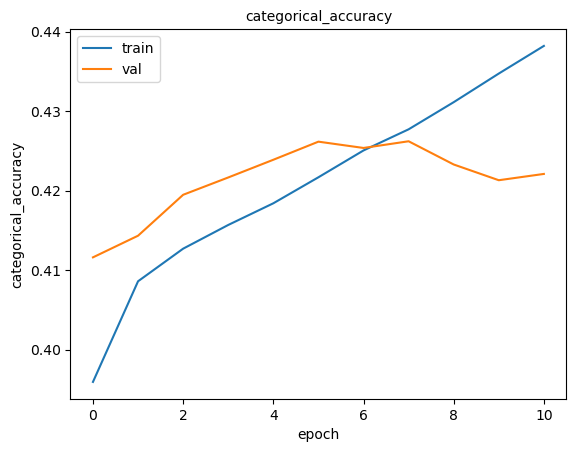

In [48]:
report_FT.plot_keras_metric("categorical_accuracy")

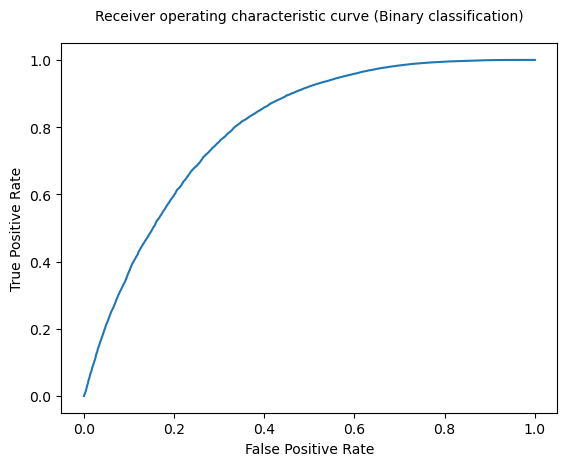

In [49]:
report_FT.plot_roc_curve_binary()

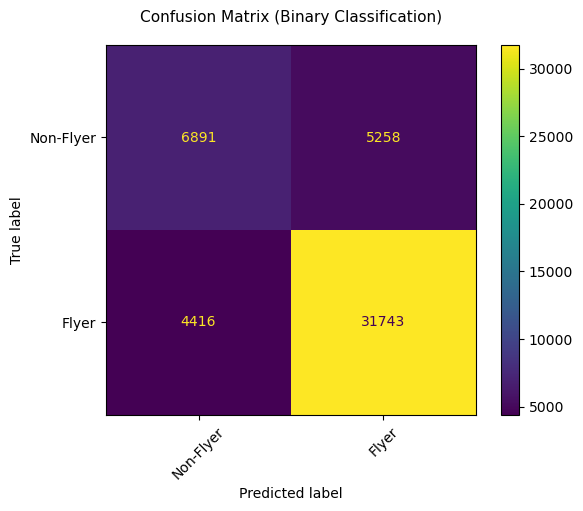

In [50]:
report_FT.plot_confusion_matrix_binary()

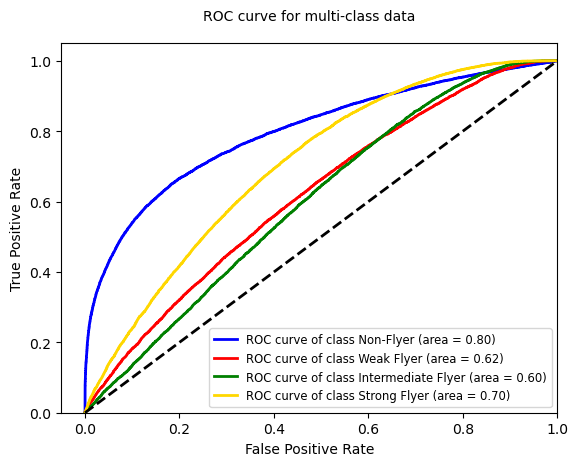

In [51]:
report_FT.plot_roc_curve()

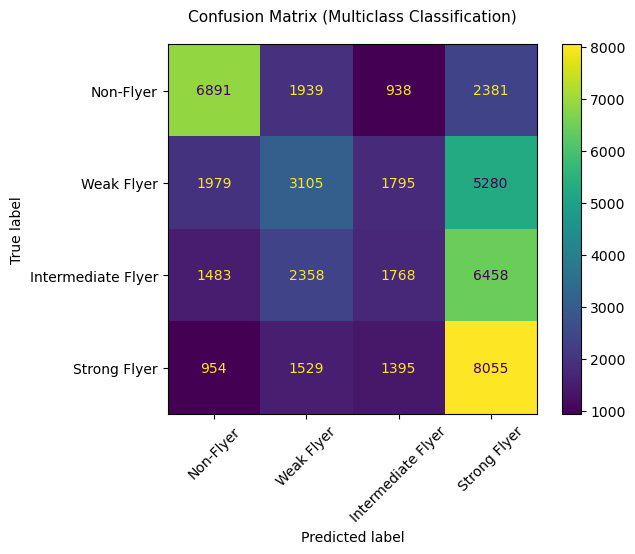

In [52]:
report_FT.plot_confusion_matrix_multiclass()

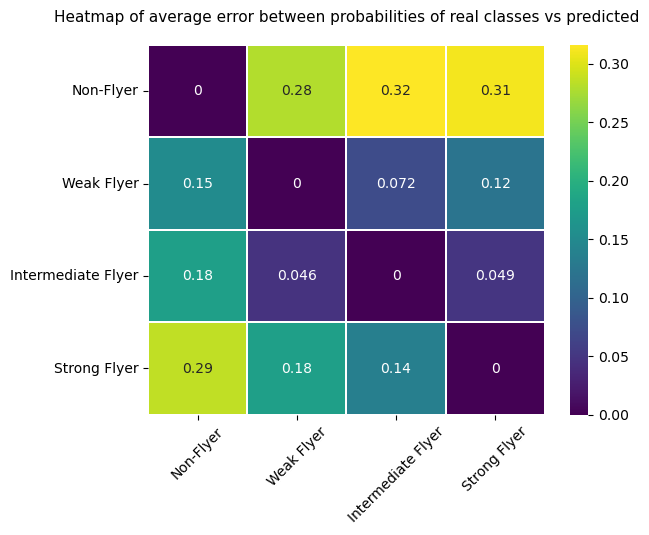

In [53]:
report_FT.plot_heatmap_prediction_prob_error()